<a href="https://colab.research.google.com/github/ramalahamir/image_classification_using_CNN/blob/main/Natural_scenes_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing datset from Kaggle


In [2]:
! pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ramalahamir","key":"4bd49f59fcb670513208fcb32748b297"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 95% 329M/346M [00:00<00:00, 484MB/s]
100% 346M/346M [00:00<00:00, 475MB/s]


In [6]:
!unzip intel-image-classification.zip -d intel-image-classification

Streaming output truncated to the last 5000 lines.
  inflating: intel-image-classification/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/

# Making our own mini CNN

In [7]:
import torch
import torch.nn as nn
import torch.optim as op
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## Prepping our datasets:

In [8]:
# making our image transformer
transformed = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [9]:
train_path = "/content/intel-image-classification/seg_train/seg_train"
test_path = "/content/intel-image-classification/seg_test/seg_test"

In [10]:
train_dataset = datasets.ImageFolder(root = train_path, transform = transformed)
test_dataset = datasets.ImageFolder(root = test_path, transform = transformed)

In [11]:
print(train_dataset.classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [12]:
print(train_dataset.class_to_idx)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


## checking if our data is balanced

In [13]:
from collections import Counter

In [14]:
print(Counter(train_dataset.targets))

Counter({3: 2512, 2: 2404, 5: 2382, 4: 2274, 1: 2271, 0: 2191})


In [15]:
print(Counter(test_dataset.targets))

Counter({2: 553, 3: 525, 4: 510, 5: 501, 1: 474, 0: 437})


data is balanced!

In [16]:
# making batches
training_batches = DataLoader(train_dataset, batch_size = 32, shuffle = True)
testing_batches = DataLoader(test_dataset, batch_size = 32)

## Defining our CNN:

In [17]:
class my_CNN(nn.Module):
   def __init__(self):
      super().__init__()

      self.my_model = nn.Sequential(
          # layer 1:
          nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3,3), padding = 1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = (2,2), stride = 2),
          # output feature map size: 64x64x32

          # layer 2:
          nn.Conv2d(32, 64, 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          # output feature map size: 32x32x64

          # flattening for the neural network
          nn.Flatten(),
          # neural network layers (making 3 layers)
          nn.Linear(in_features = 32*32*64, out_features = 128),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Linear(128, 64),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.Linear(64, 6),    # since 6 classes

          nn.Dropout(0.3)
      )

   def forward(self, image_batch):
     return self.my_model(image_batch)

## Training the model

In [18]:
miniCnn = my_CNN()
miniCnn.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
miniCnn.to(miniCnn.device)
loss_func = nn.CrossEntropyLoss()
optimizer = op.Adam(miniCnn.parameters(), lr = 0.0001)

In [19]:
print("Using device:", miniCnn.device)


Using device: cuda


In [20]:
counter = 0
patience = 10
best_acc = 0

for epoch in range(50):

  miniCnn.train()
  total_loss = 0

  for images, labels in training_batches:
    images, labels = images.to(miniCnn.device), labels.to(miniCnn.device)

    optimizer.zero_grad()
    outputs = miniCnn(images)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # validating the model
  miniCnn.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in testing_batches:
      images, labels = images.to(miniCnn.device), labels.to(miniCnn.device)

      outputs = miniCnn(images)   # getting a tensor of class scores
      _, predicted = torch.max(outputs.data, 1)   # finding the max along horizontal axis
      total += labels.size(0)  # getting the batch size
      correct += (predicted == labels).sum().item()

  accuracy = 100*correct/total
  print(f"Epoch: ", {epoch}, " loss: ", {total_loss}, " accuracy: ", {accuracy})

  if accuracy > best_acc:
    best_acc = accuracy
    counter = 0
    torch.save(miniCnn.state_dict(), "best_model.pth")
  else:
    counter += 1
    if counter >= patience:
      print("Early stopping triggered")
      break

Epoch:  {0}  loss:  {562.286913394928}  accuracy:  {69.03333333333333}
Epoch:  {1}  loss:  {482.4967017173767}  accuracy:  {71.93333333333334}
Epoch:  {2}  loss:  {445.5345510840416}  accuracy:  {73.66666666666667}
Epoch:  {3}  loss:  {422.9620782136917}  accuracy:  {74.76666666666667}
Epoch:  {4}  loss:  {410.6631752848625}  accuracy:  {75.96666666666667}
Epoch:  {5}  loss:  {395.8926823437214}  accuracy:  {77.1}
Epoch:  {6}  loss:  {386.08700400590897}  accuracy:  {75.7}
Epoch:  {7}  loss:  {378.54674208164215}  accuracy:  {78.33333333333333}
Epoch:  {8}  loss:  {367.1762602031231}  accuracy:  {78.13333333333334}
Epoch:  {9}  loss:  {366.5224378108978}  accuracy:  {79.16666666666667}
Epoch:  {10}  loss:  {358.32959523797035}  accuracy:  {79.4}
Epoch:  {11}  loss:  {354.11201399564743}  accuracy:  {79.26666666666667}
Epoch:  {12}  loss:  {345.68391782045364}  accuracy:  {79.73333333333333}
Epoch:  {13}  loss:  {341.76545479893684}  accuracy:  {79.66666666666667}
Epoch:  {14}  loss:  {

## Testing our best trained model




In [21]:
# making a new model according to saved best states
my_model = my_CNN().to(miniCnn.device)
my_model.load_state_dict(torch.load("best_model.pth"))
my_model.eval()

my_CNN(
  (my_model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=65536, out_features=128, bias=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=64, out_features=6, bi

In [23]:
from PIL import Image
import random
import os

(np.float64(-0.5), np.float64(149.5), np.float64(149.5), np.float64(-0.5))

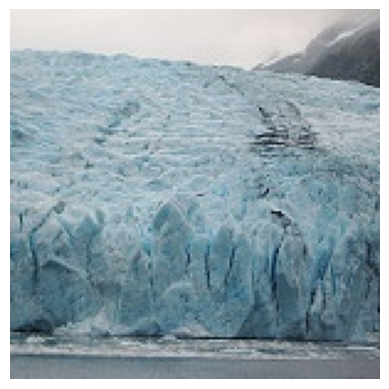

In [34]:
# prepping our image for testing
folder = "/content/intel-image-classification/seg_pred/seg_pred"
img_path = folder + "/" + random.choice(os.listdir(folder))
img = Image.open(img_path)
img = img.convert("RGB")

plt.imshow(img)
plt.axis("off")

In [35]:
img = transformed(img)
img = img.unsqueeze(0)  # adding batch size
img = img.to(miniCnn.device)

In [36]:
with torch.no_grad():
  output = my_model(img)
  _,predicted_class = torch.max(output.data, 1)

classes = {0 : 'buildings', 1 : 'forest', 2 : 'glacier', 3 : 'mountain', 4 : 'sea', 5 : 'street'}
print ("class: ", classes[predicted_class.item()])

class:  glacier
